In [14]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *

In [2]:
classes = 62
im_side = 64

In [3]:
df = pd.read_csv(
    "english.csv",
    dtype={"image": pd.StringDtype(), "label": pd.CategoricalDtype()}
)

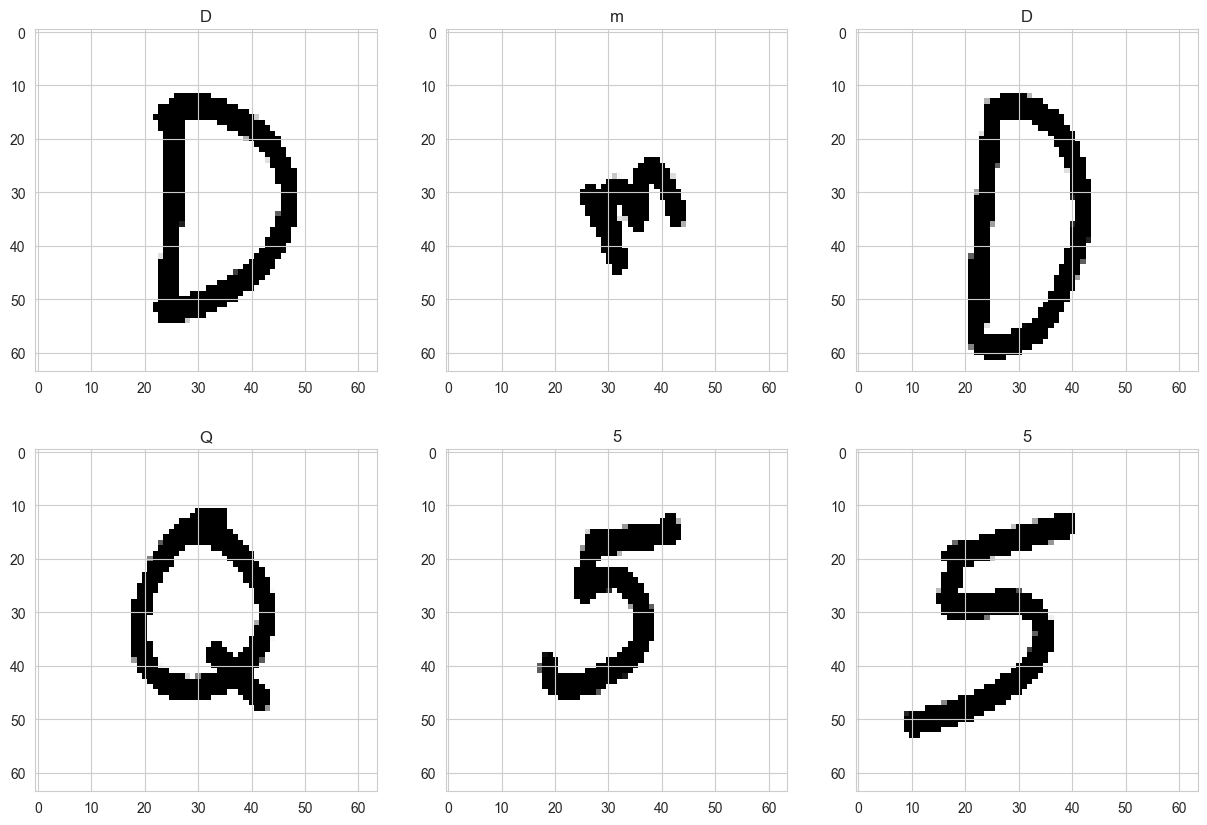

In [4]:
plt.figure(figsize=(15, 10))
for i, idx in enumerate(np.array(df.sample(6))):
    img = cv2.imread(idx[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (im_side, im_side))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(idx[1])
plt.show()

In [5]:
labels = df.loc[:, "label"].values
images = []
for i in df.loc[:, "image"].values:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (im_side, im_side))
    images.append(np.array(img))

In [6]:
images = np.array(images)

In [7]:
Encoder = LabelEncoder()
labels = Encoder.fit_transform(labels)

In [8]:
x1, x2, y1, y2 = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
x1 = x1 / 255.
x2 = x2 / 255.

In [10]:
model = Sequential([
    Input(shape=(im_side, im_side, 3)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(3, 3),
    Conv2D(1024, (5, 5), activation='relu'),
    MaxPooling2D(3, 3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='sigmoid'),
    Dense(classes, activation='softmax')
])

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
MCP = ModelCheckpoint('HCR.h5', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
ES = EarlyStopping(monitor='val_accuracy', min_delta=0, verbose=0, restore_best_weights=True, patience=3, mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)

In [13]:
history = model.fit(x1, y1, epochs=10, validation_data=(x2, y2), callbacks=[MCP, ES, RLP])

Epoch 1/10
86/86 [==============================] - ETA: 0s - loss: 3.6653 - accuracy: 0.1371
Epoch 1: val_accuracy improved from -inf to 0.33284, saving model to HCR.h5
86/86 [==============================] - 60s 688ms/step - loss: 3.6653 - accuracy: 0.1371 - val_loss: 2.6424 - val_accuracy: 0.3328 - lr: 0.0010
Epoch 2/10
86/86 [==============================] - ETA: 0s - loss: 1.8420 - accuracy: 0.5700
Epoch 2: val_accuracy improved from 0.33284 to 0.64663, saving model to HCR.h5
86/86 [==============================] - 72s 835ms/step - loss: 1.8420 - accuracy: 0.5700 - val_loss: 1.4764 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 3/10
86/86 [==============================] - ETA: 0s - loss: 0.9709 - accuracy: 0.7830
Epoch 3: val_accuracy improved from 0.64663 to 0.73314, saving model to HCR.h5
86/86 [==============================] - 71s 825ms/step - loss: 0.9709 - accuracy: 0.7830 - val_loss: 1.0654 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 4/10
86/86 [==============================]

In [15]:
random_indices = random.sample(range(len(x2)), 6)

In [16]:
def predict(images):
    pred = model.predict(images)
    return np.argmax(pred, axis=1)


def decode_labels(labels):
    return Encoder.inverse_transform(labels)

In [17]:
y_pred = predict(x2[random_indices])

1/1 [==============================] - 0s 118ms/step


In [18]:
y_pred_label = decode_labels(y_pred)

In [19]:
y_pred_true_label = decode_labels(y2[random_indices])

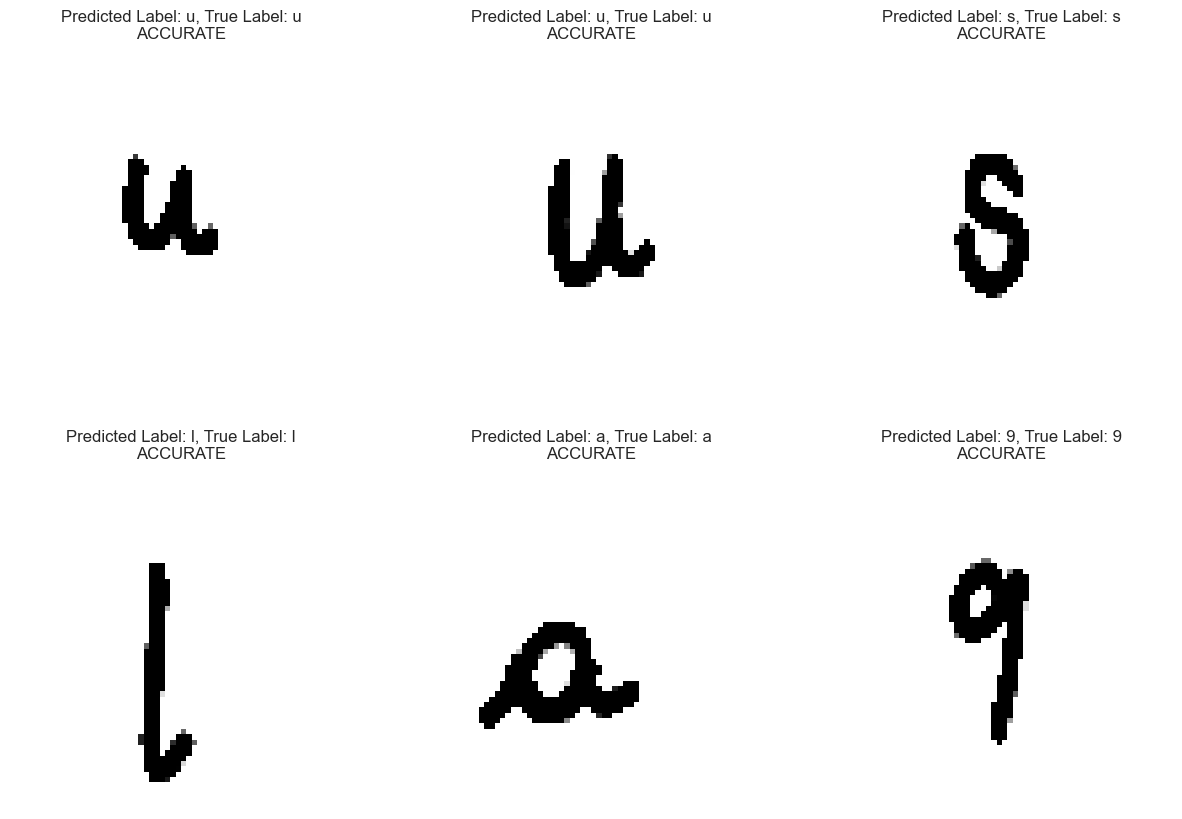

In [20]:
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x2[idx])
    if y_pred_label[i] == y_pred_true_label[i]:
        val = 'ACCURATE'
    else:
        val = 'INACCURATE'
    plt.title(f'Predicted Label: {y_pred_label[i]}, True Label: {y_pred_true_label[i]}\n{val}')
    plt.axis('off')
plt.show()

Text(0, 0.5, 'Accuracy')

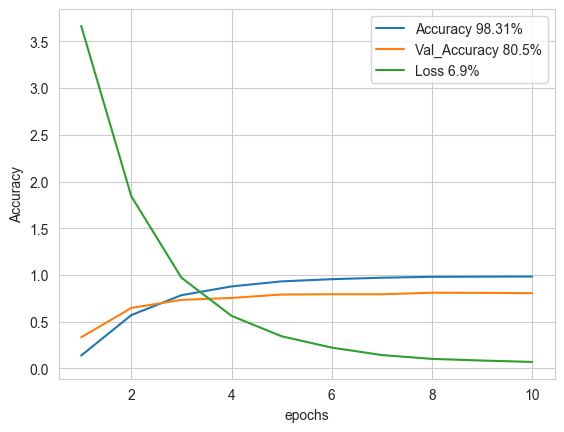

In [32]:
q = len(history.history['accuracy'])
plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label=f'Accuracy {round(history.history["accuracy"][-1] * 100, 2)}%')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label=f'Val_Accuracy {round(history.history["val_accuracy"][-1] * 100, 2)}%')
sns.lineplot(x = range(1,1+q),y = history.history['loss'], label=f'Loss {round(history.history["loss"][-1] * 100, 2)}%')
plt.xlabel('epochs')
plt.ylabel('Accuracy')

In [22]:
pred_labels = predict(x2)
print(pred_labels)
print(decode_labels(y2))
# pred_labels = predict(x2[random_indices])
# print(pred_labels)
# print(decode_labels(y2[random_indices]))

22/22 [==============================] - 2s 68ms/step
[57 32 42 38  0 55 32 26 41 26 29 59  3 20 18 54 32  0 17 29 48 54 48 48
  0  6  8 42 16 61 47 15 50 35 50  0  7 53 59  5 44  7  0  9  4 49 58 52
 13 40 52 55 60 38 26 41 42 49 27 57 39 29 32 15 55 19 48 45 31 61 13  2
  0 59 52 55 27 57 50 13 56 58 10 23 31 54  0 29 59 43 22  5 48  8 47 20
 47 32 34  3 39 32 47  0 49  3 13  8 54 15 31 37 12  5  4 18 31  0  2 37
  7  8 21 53 12 14 47 56 13 49 50 46 52 46 50 46 29  5 47 54 27 11 46 60
 33 41 19  3 19 57 10 47 23 16 51 44 58 56 51 27 38  5 54 14  4 14 14  6
 13 15 31  6 40  4 28 18  3 30 21 20 42 38 61 25  7 22 40 61  5  4 48 37
 58 14 32 43 58  9  5 22 17 20  3  9  8 61 29 18 13 55  7 24 44 49 27 25
 45 55 39 54 10 46 16  7  3 61 36 36 54 15  5  3 32  1  0 47 19 59 40  5
 30 46  5 46 61 50 39 16  0 60 46  1 26  5 33 30 38 52 34 28 21 17 16 61
  3 23 52  1 23 26 46  7 46 26 28 56 56 45 52  0 45 15 15  5 49 36 55  2
 22 22 50 39  4  1 56 47 20 14 10 61  3 59  5 59  7  0 28 49 53 48  0 

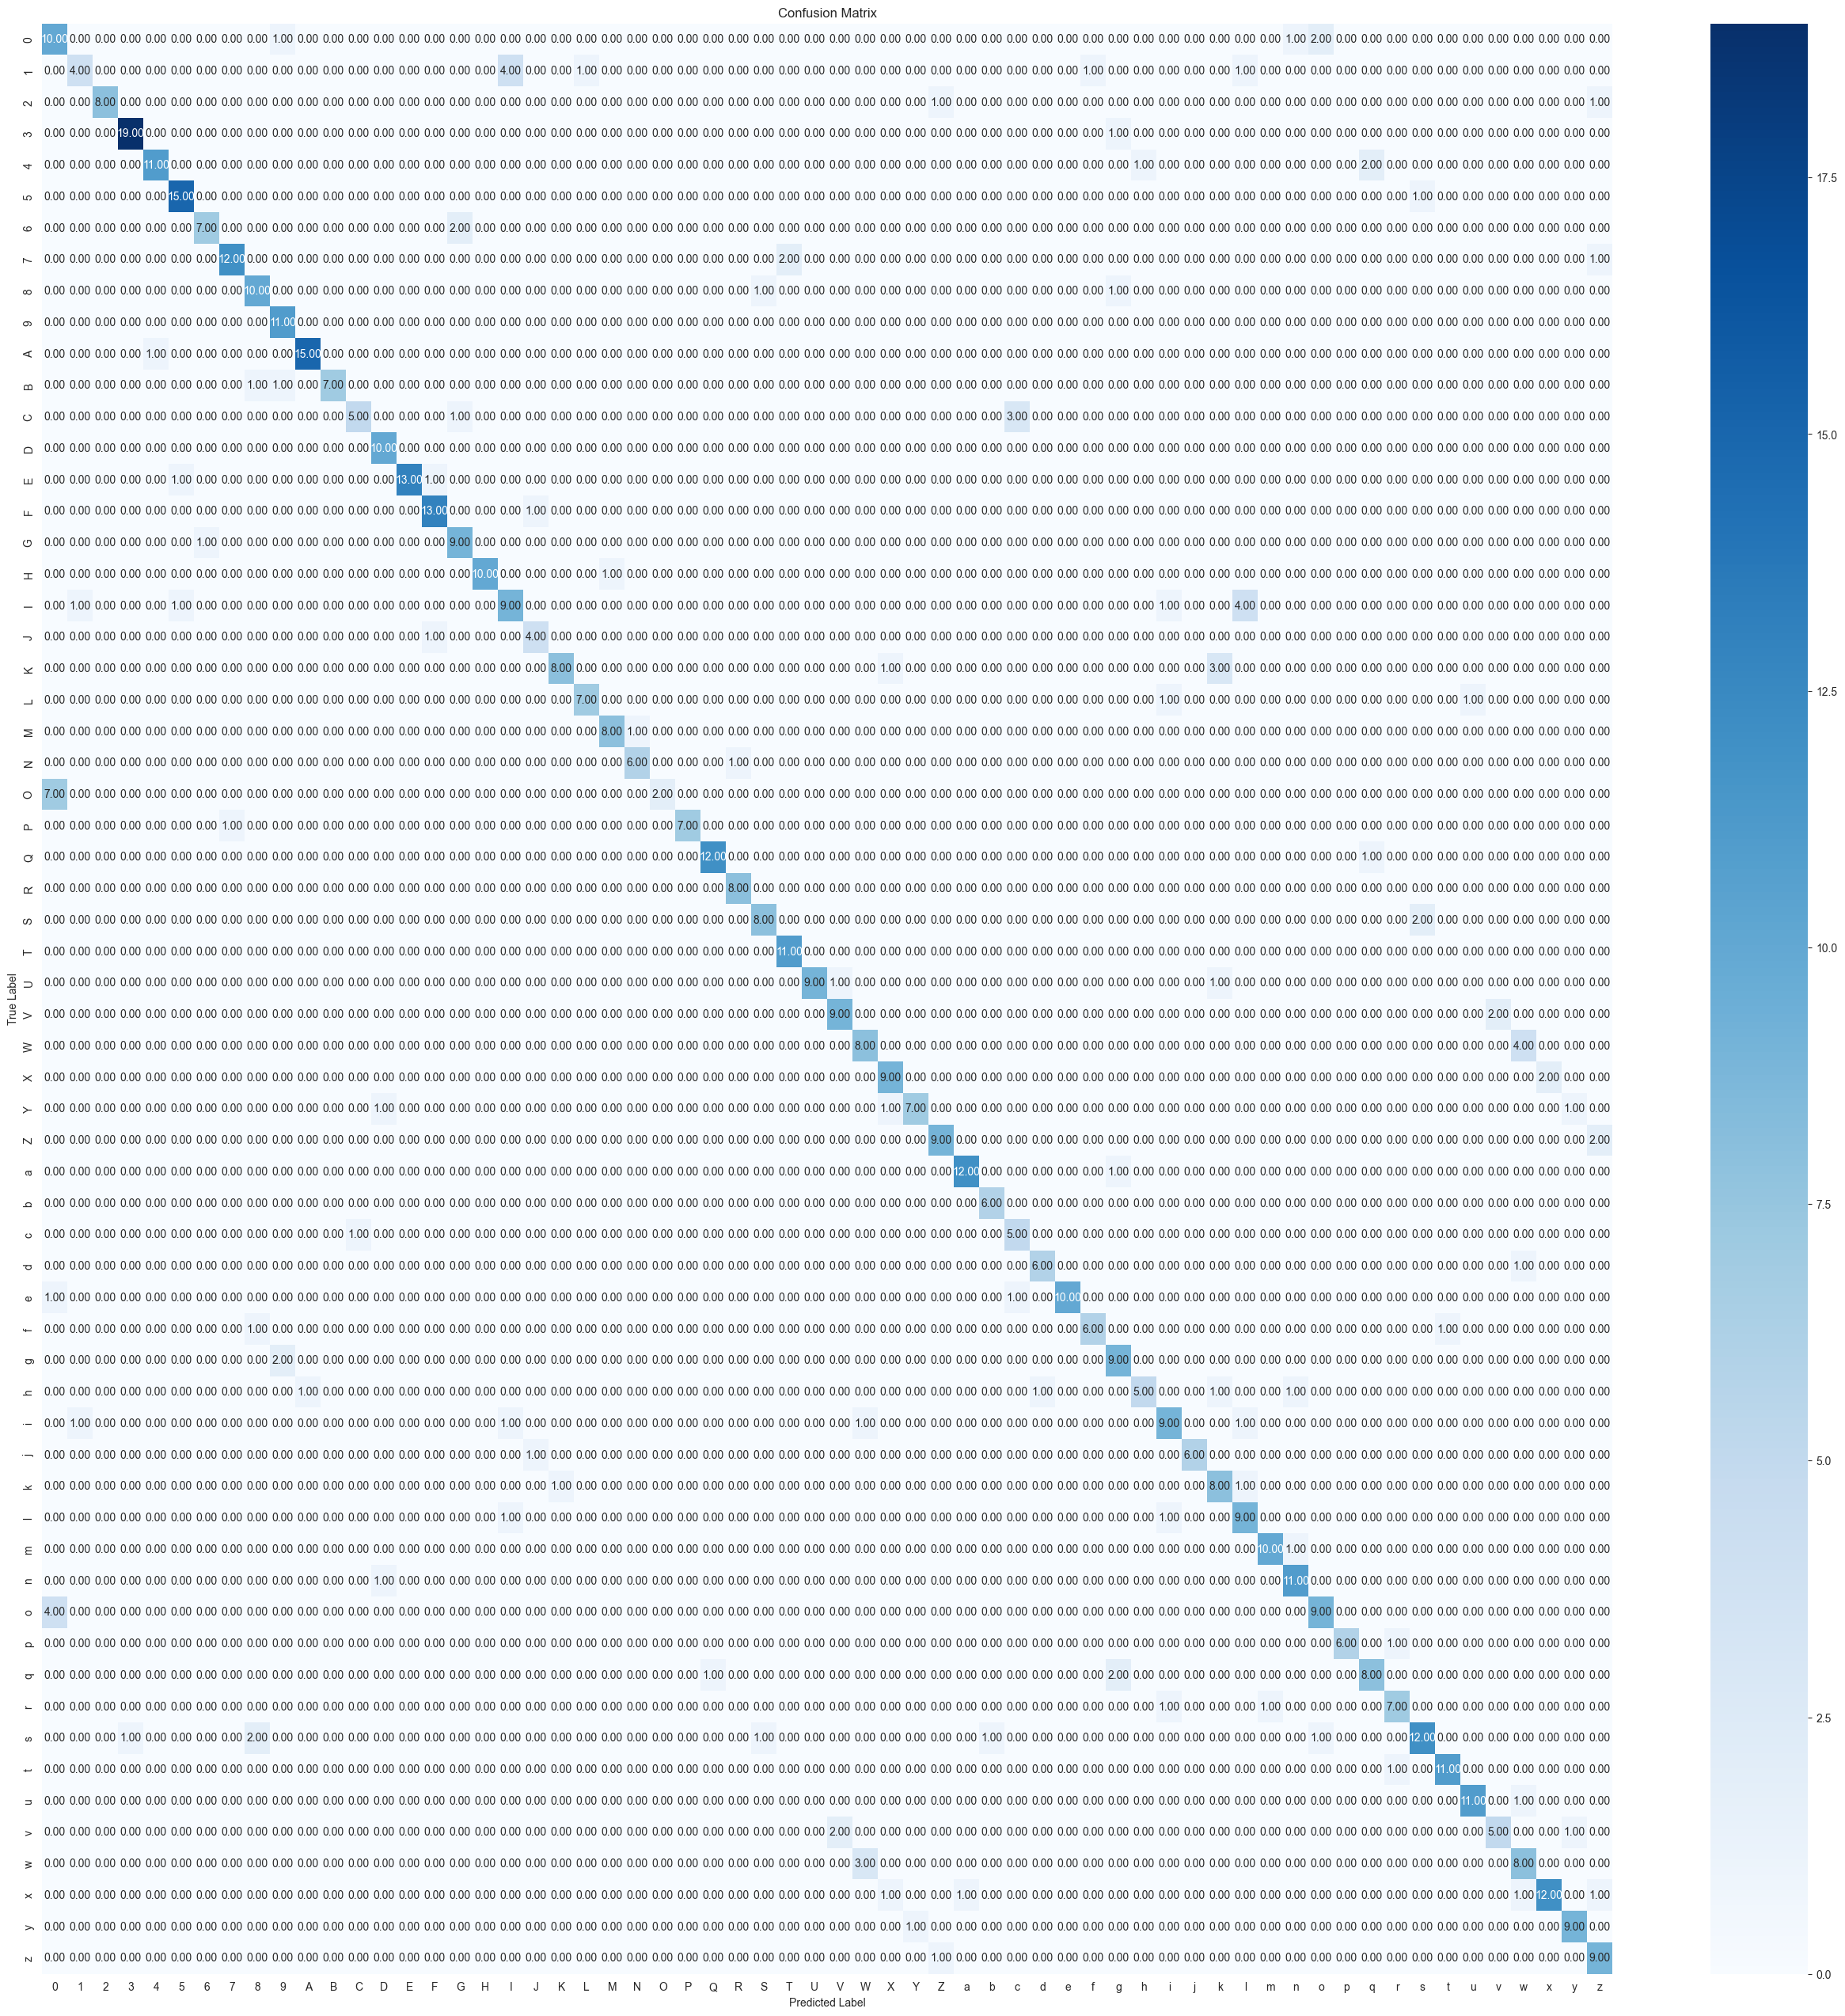

In [23]:
conf_matrix = confusion_matrix(y2, pred_labels)
plt.figure(figsize=(32, 32))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
# conf_matrix = confusion_matrix(y2[random_indices], pred_labels)
# plt.figure(figsize=(16, 16))
# sns.heatmap(conf_matrix, annot=True, cmap='twilight_shifted', fmt='.2f', xticklabels=decode_labels(y2[random_indices]), yticklabels=decode_labels(y2[random_indices]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
metrics = dict()
metrics['accuracy'] = accuracy_score(y2, pred_labels)
metrics['precision'] = precision_score(y2, pred_labels, average='weighted')
metrics['recall'] = recall_score(y2, pred_labels, average='weighted')
metrics['f1_score'] = f1_score(y2, pred_labels, average='weighted')
for a, b in metrics.items():
    print(a, round(b * 100, 2))

accuracy 80.5
precision 82.31
recall 80.5
f1_score 80.42


In [30]:
for a, b in history.history.items():
    print(a, round(b[-1] * 100, 2))

loss 6.9
accuracy 98.31
val_loss 66.87
val_accuracy 80.5
lr 0.1
